# Table of Contents
* [Assignment 5: Control a Marble with Reinforcement Learning](#Assignment-5:-Control-a-Marble-with-Reinforcement-Learning)
	* [Overview](#Overview)
	* [Start with This Code](#Start-with-This-Code)
	* [Requirements](#Requirements)
	* [Grading](#Grading)
	* [Extra Credit](#Extra-Credit)
	* [Check-in](#Check-in)


$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

Yashad Samant

## Overview

In this assignment, we were initially given code which trains the q values for a single goal position. Our objective is to implement a system where we train q values for various goals and later test it on certain goals among them, to see if the learning is intact.

## Start with This Code

We have used the following code which was given in class:

* `marble.py`
* `neuralnetworksbylayer.py`
* `layers.py`
* `scaledconjugategradient.py`
* `mlutils.py`

In [78]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

For the reinforcement problem, we have defined four functions:

* initialState - It gives the initial location of the marble. As the problem suggests, it also includes the goal array which is then further propagated to reinforcement funtion.

* nextState - It gives the next state of the marble using the Euler integration method. We also cusion the function for if it goes beyond the marble space. If it goes below 0, we get value as 0, and if marble goes above 10, we keep the value 10.

* reinforcement - It is a function which compares between the next state and the goal with the error of 1. We can reduce 1 to any smaller value to reduce the error. But reinforcement learning takes a lot of time to converge, hence error of 1 seems to be a good value. If the values are not close, it gives a reinforcement of -0.1.

* policy - It decides the action to be taken on the basis of the reinforcement.

In [79]:
validActions = np.array([ -1, 0, 1])

def initialState(i):
    goal = [0,1,2,3,4,5,6,7,8,9,10]
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()),goal[i]])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s[0:2] = np.array([0,0])
    elif s[0] > 10:
        s[0:2] = np.array([10,0])
    return np.array([s,goal])

def reinforcement(s,goal):  # s is new state
    print (s)
    print(goal)
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

makeSamples generates samples on the basis of the previously mentioned functions. It's output is current state, action, reinforcement, new state and new action. This is the SARSA list which is inserted in the neural network to learn the Q values.

In [92]:
def makeSamples(qnet, nStepsPerStart,i):
    j = 0
    j = j+1
    samples = []
    state = initialState(i)
    print (state)
    act = policy(qnet, state[0:2], epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state[0:2], act)
        r = reinforcement(newState[0:2], state[2])
        print (r)
        newAct = policy(qnet, newState[0:2], epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
        print(j)
    return np.array(samples)

Now we can play.  Define constants we need.

In [93]:
def plotStatus(qnet, X, R, trial, epsilonTrace, rtrace):
    plt.subplot(4,3,1)
    plt.plot(epsilonTrace[:trial+1])
    plt.ylabel("Random Action Probability ($\epsilon$)")
    plt.ylim(0,1)
    plt.subplot(4,3,2)
    plt.plot(X[:,0])
    plt.plot([0,X.shape[0]], [5,5],'--',alpha=0.5,lw=5)
    plt.ylabel("$x$")
    plt.ylim(-1,11)
    #qs = [[qnet.use([s,0,a]) for a in actions] for s in range(11)]
    qs = qnet.use(np.array([[s,0,a] for a in validActions for s in range(11)]))
    #print np.hstack((qs,-1+np.argmax(qs,axis=1).reshape((-1,1))))
    plt.subplot(4,3,3)
    acts = ["L","0","R"]
    actsiByState = np.argmax(qs.reshape((len(validActions),-1)),axis=0)
    for i in range(11):
        plt.text(i,0,acts[actsiByState[i]])
        plt.xlim(-1,11)
        plt.ylim(-1,1)
    plt.text(2,0.2,"Policy for Zero Velocity")
    plt.axis("off")
    plt.subplot(4,3,4)
    plt.plot(rtrace[:trial+1],alpha=0.5)
    #plt.plot(np.convolve(rtrace[:trial+1],np.array([0.02]*50),mode='valid'))
    binSize = 20
    if trial+1 > binSize:
        # Calculate mean of every bin of binSize reinforcement values
        smoothed = np.mean(rtrace[:int(trial/binSize)*binSize].reshape((int(trial/binSize),binSize)),axis=1)
        plt.plot(np.arange(1,1+int(trial/binSize))*binSize,smoothed)
    plt.ylabel("Mean reinforcement")
    plt.subplot(4,3,5)
    plt.plot(X[:,0],X[:,1])
    plt.plot(X[0,0],X[0,1],'o')
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.fill_between([goal-1,goal+1],[-5,-5],[5,5],color="red",alpha=0.3)
    plt.xlim(-1,11)
    plt.ylim(-5,5)
    plt.subplot(4,3,6)
    qnet.draw(["$x$","$\dot{x}$","$a$"],["Q"])

    plt.subplot(4,3,7)
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    #states = np.vstack((xs.flat,ys.flat)).T
    #qs = [qnet.use(np.hstack((states,np.ones((states.shape[0],1))*act))) for act in actions]
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],a] for a in validActions for i in range(len(xsflat))]))
    #qs = np.array(qs).squeeze().T
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Max Q")
    plt.subplot(4,3,8)
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("$x$")
    plt.ylabel("$\dot{x}$")
    plt.title("Actions")

    s = plt.subplot(4,3,10)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,qsmax,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Max Q")
    plt.title("Max Q")

    s = plt.subplot(4,3,11)
    rect = s.get_position()
    ax = Axes3D(plt.gcf(),rect=rect)
    ax.plot_surface(xs,ys,acts,cstride=1,rstride=1,cmap=cm.viridis,linewidth=0)
    ax.set_xlabel("$x$")
    ax.set_ylabel("$\dot{x}$")
    #ax.set_zlabel("Action")
    plt.title("Action")

def testIt(qnet,nTrials,nStepsPerTrial):
    xs = np.linspace(0,10,nTrials)
    plt.subplot(4,3,12)
    for x in xs:
        s = [x,0] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,2))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([5,5],[-5,5],'--',alpha=0.5,lw=5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

In [94]:
gamma = 0.999
nTrials = 300
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value

In [95]:
epsilonDecay

0.98476665211015812

In [96]:
nh = [25,25]
qnet = nn.NeuralNetwork([3] + nh + [1])  # [3, 10, 10, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (-1,1)))

In this code, we can vary gamma, nTrials, nStepsPerTrial, nSCGIterations.
* gamma is the learning rate, it decides how fast the network converges. I varied it to 0.7 and saw that the net converged in relatively less time, but output was not very accurate. We see that reinforcement learning has relatively larger errors than previously designed supervised learning models, hence it's better to keep gamma as 0.999.

* nTrials is the number of times the samples are going to be trained on the network. I increased the trials to 1000 to check if it improves the values but observed that it does not happen. It may be because the model may be over-fitted to learn more values and thus, give rise to errors instead of error less output. But if we increase the hidden layers, it was in a better position to handle the over-fitting problem and gave better output.

* nStepsPerTrial are the number of samples. More the number of samples better the output. But I found that for a 5,5 hidden layer 700 samples were more than enough. 1000 samples were not improving the performance of the net in any way.

* nSCGIterations didn't give any significant results even if we increase it to 80. 

In [97]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for i in range(10):
    for trial in range(nTrials):

        # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
        samples = makeSamples(qnet, nStepsPerTrial,i)

        ns = 2
        na = 1
        X = samples[:, :ns+na]
        R = samples[:, ns+na:ns+na+1]
        nextX = samples[:, ns+na+1:]
        nextQ = qnet.use(nextX)

        qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
        epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
        epsilonTrace[trial] = epsilon
        rtrace[trial] = np.mean(R)

    if trial % (nTrials//10) == 0 or trial == nTrials-1:
        plt.clf()
        #plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
        testIt(qnet,10,500)
        #clear_output(wait=True)
        display(fig);
        plt.pause(0.01)

        # print('Trial',trial,'mean R',np.mean(R))
    #clear_output(wait=True)

[ 8.44491159 -0.60222911  0.        ]
[array([ 8.38468868, -0.39018453]) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]
0.0


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Testing output with goals 1, 5 and 9

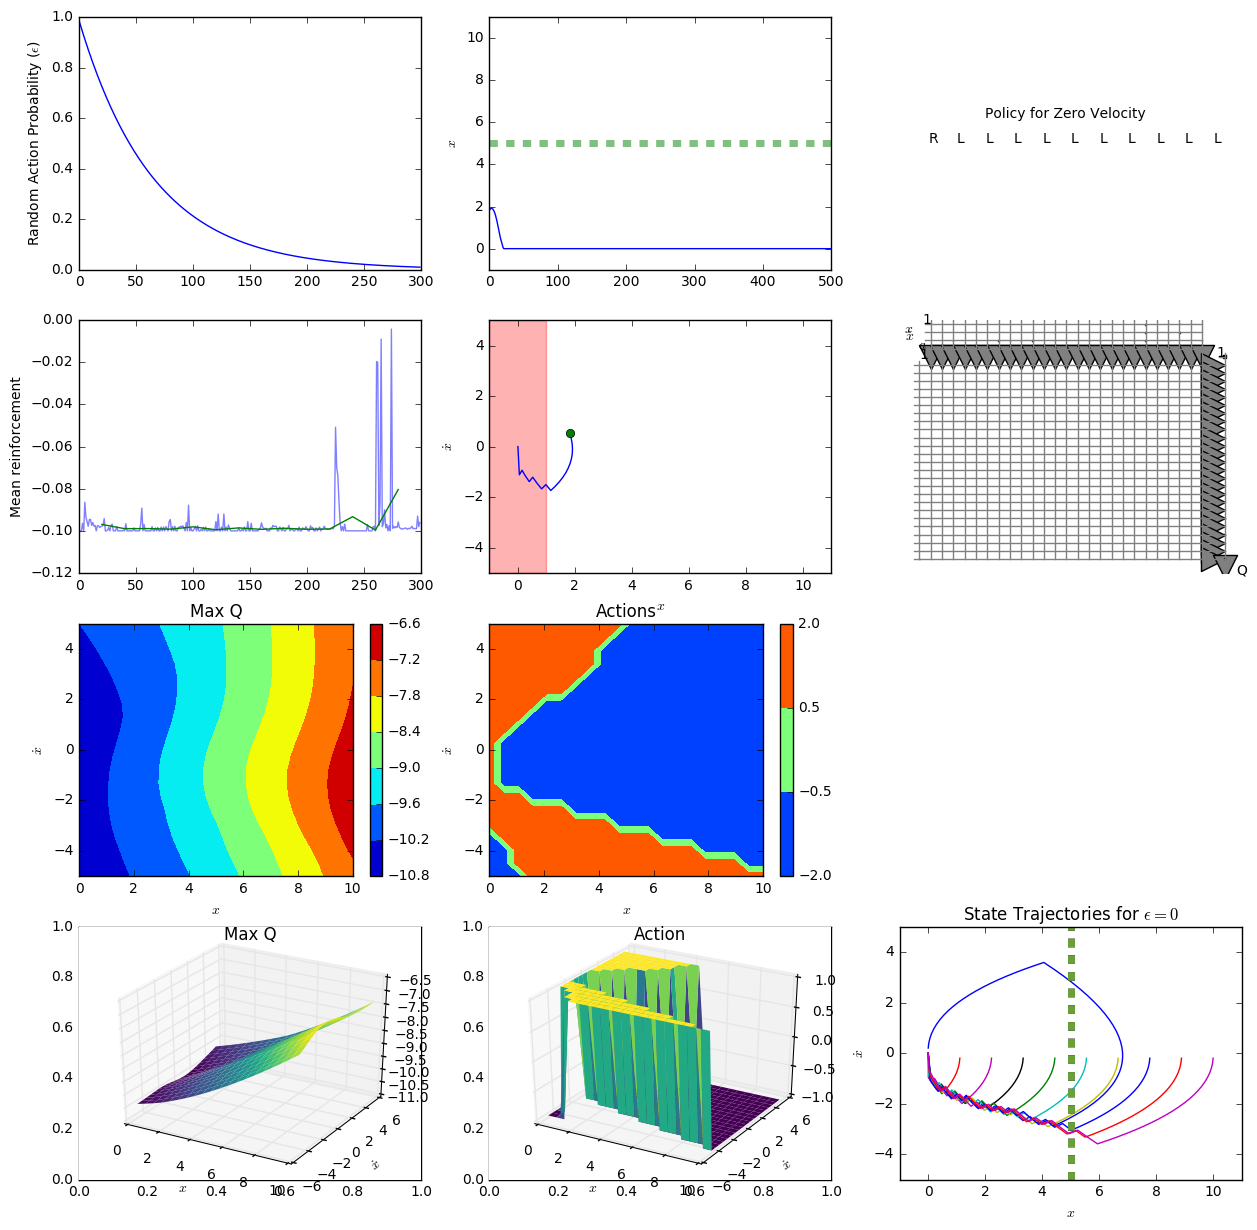

In [33]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,1)

    ns = 2
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
    epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)
        
if trial % (nTrials//10) == 0 or trial == nTrials-1:
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
    testIt(qnet,10,500)
    #clear_output(wait=True)
    display(fig);
    plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

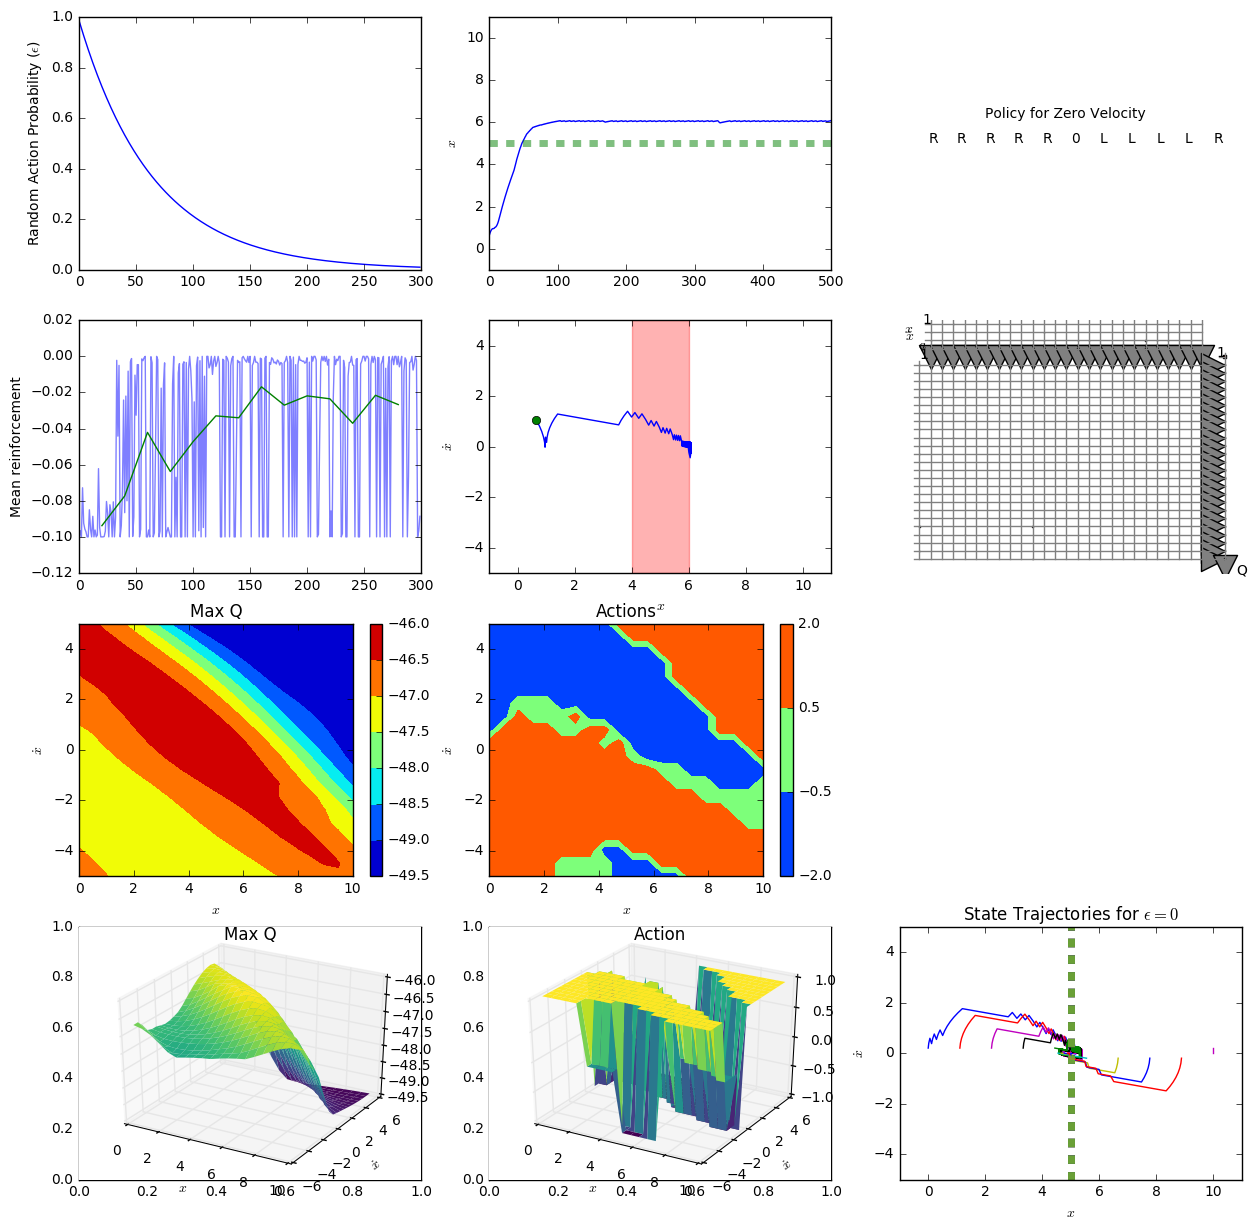

In [17]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,5)

    ns = 2
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
    epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)
        
if trial % (nTrials//10) == 0 or trial == nTrials-1:
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
    testIt(qnet,10,500)
    #clear_output(wait=True)
    display(fig);
    plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

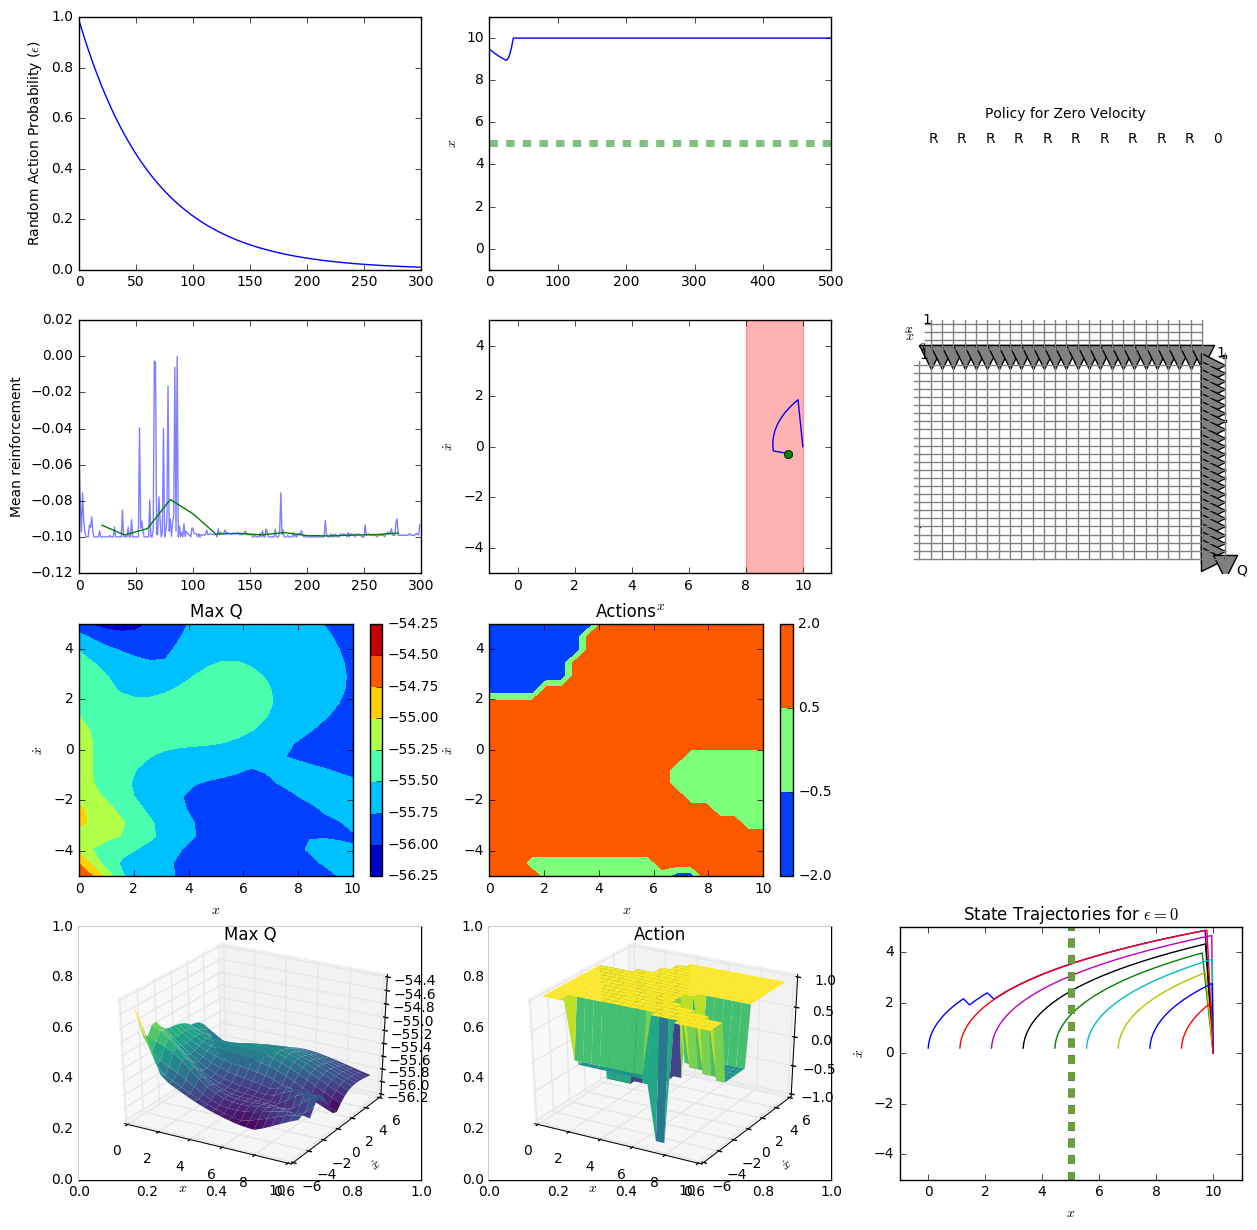

In [18]:
fig = plt.figure(figsize=(15,15))

epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)

for trial in range(nTrials):

    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial,9)

    ns = 2
    na = 1
    X = samples[:, :ns+na]
    R = samples[:, ns+na:ns+na+1]
    nextX = samples[:, ns+na+1:]
    nextQ = qnet.use(nextX)

    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

        # Decay epsilon
    epsilon *= epsilonDecay
        # epsilon = max(0.01, epsilon)

        # Rest is for plotting
    epsilonTrace[trial] = epsilon
    rtrace[trial] = np.mean(R)
        
if trial % (nTrials//10) == 0 or trial == nTrials-1:
    plt.clf()
    plotStatus(qnet, X, R, trial,epsilonTrace,rtrace)
    testIt(qnet,10,500)
    #clear_output(wait=True)
    display(fig);
    plt.pause(0.01)

    # print('Trial',trial,'mean R',np.mean(R))
clear_output(wait=True)

## Grading

To grade this notebook, we will run your complete notebook and read the results.  There is no automatic grading code for this notebook.  Do your best to show code and results you used to find good parameter values, to train your successful Q network, and to demonstrate that it is successful.

Include text to explain what you did, how successful it was, and any problems you encountered.

## Check-in

Do not include this section in your notebook.

Name your notebook ```Lastname-A5.ipynb```.  So, for me it would be ```Anderson-A5.ipynb```.  Submit the file using the ```Assignment 5``` link on [Canvas](https://colostate.instructure.com/courses/41327).
